In [1]:
import itertools
from operator import itemgetter
import requests, zipfile, io, csv
# from pathos.pools import ProcessPool
import random
import os.path
import concurrent.futures
from functools import partial
import boto3
import botocore
import s3fs
import pandas as pd
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import calplot
from datetime import datetime
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 20)
colors_div = ['#FF8A33','lightgreen', '#6351D3', '#D35151','#FF33E6']

In [60]:
session = boto3.Session(profile_name='kandavar_processing')
s3 = session.client('s3')
bucket_name = 'statsnz-covid-kandavar'

def read_from_s3(d,filename):
    
    session = boto3.Session(profile_name='kandavar_processing')
    s3 = session.client('s3')
    bucket_name = 'statsnz-covid-kandavar'
    
    
    obj = s3.get_object(Bucket = bucket_name, Key = 'G_from_2015/'+f'{d}'+filename)
    d = pd.read_csv(obj['Body'], parse_dates=['date'])
    d= d.loc[d.date>=datetime(2015,3,1)]
    

#     d = pd.read_csv(obj['Body'], parse_dates = ['date'], usecols = [2,4,6,10])  # for au there is unnamed column at the start
     
#     d['date'] = d.date.dt.date
    print(f"Read - {filename}")
    print(d.info())
    return d

In [133]:
df = read_from_s3('','swa_gdelt_final_monthly.csv')

Read - swa_gdelt_final_monthly.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 1 to 304
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       301 non-null    datetime64[ns]
 1   housing                    301 non-null    float64       
 2   no.articles_housing        301 non-null    int64         
 3   Unemployment               301 non-null    float64       
 4   no.articles_Unemployment   301 non-null    int64         
 5   Mental_health              301 non-null    float64       
 6   no.articles_Mental_health  301 non-null    int64         
 7   Wellbeing                  285 non-null    float64       
 8   no.articles_Wellbeing      285 non-null    float64       
 9   Vaccination                301 non-null    float64       
 10  no.articles_Vaccination    301 non-null    int64         
 11  Coronavirus                105 non-n

In [140]:
df.head()

,date,housing,no.articles_housing,Unemployment,no.articles_Unemployment,Mental_health,no.articles_Mental_health,Wellbeing,no.articles_Wellbeing,Vaccination,no.articles_Vaccination,Coronavirus,no.articles_Coronavirus,country,year
1,2015-03-31,-0.832774,3325,-1.644335,3471,-2.058962,2057,NaN,NaN,-1.602998,799,NaN,0.0,au,2015
2,2015-04-30,-0.866566,3487,-1.926652,2940,-1.990678,3004,NaN,NaN,-2.083010,1519,NaN,0.0,au,2015
3,2015-05-31,-1.172784,4798,-1.665709,4230,-2.246245,2333,NaN,NaN,-1.514834,929,NaN,0.0,au,2015
4,2015-06-30,-1.462560,5632,-1.415975,3237,-1.998128,1999,NaN,NaN,-1.660276,685,-4.416159,99.0,au,2015
5,2015-07-31,-0.494129,3271,-1.402582,2712,-2.027818,11087,-2.152208,10212.0,-3.390658,387,-3.144654,4.0,au,2015


In [134]:
# df['date'] = pd.to_datetime(df['date'], errors="coerce")
# df = df.loc[df.date >=datetime(2015,3,1)]
df['year'] = df.date.dt.year

In [135]:
# df.groupby(['country','year'])['no.articles_Coronavirus'].sum().reset_index().head(20)

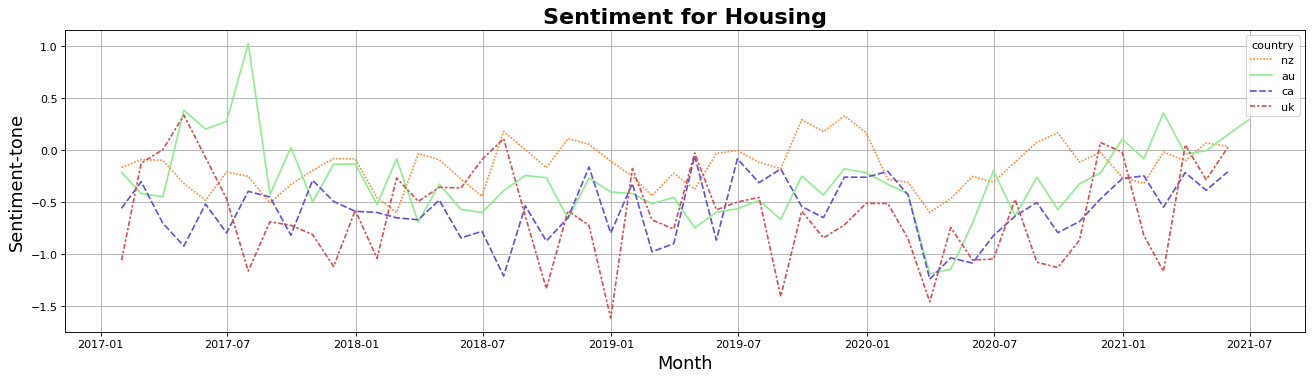

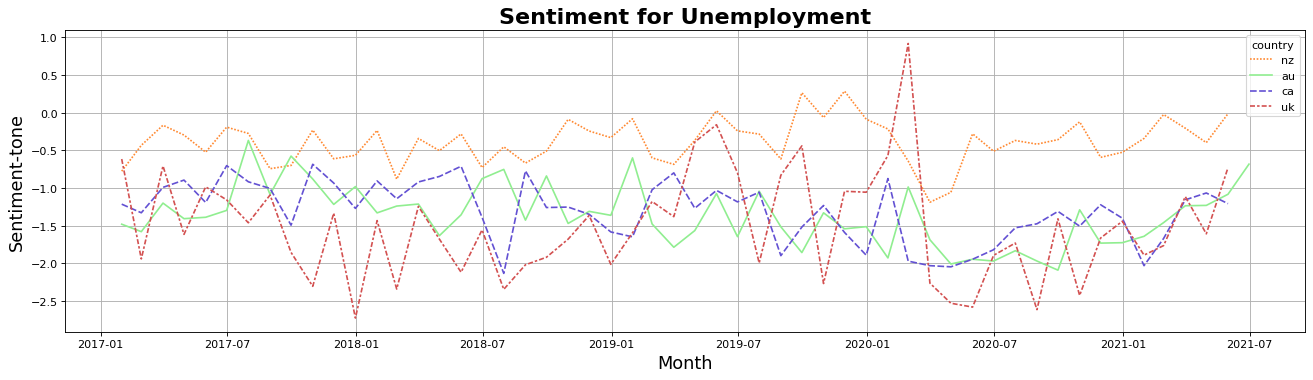

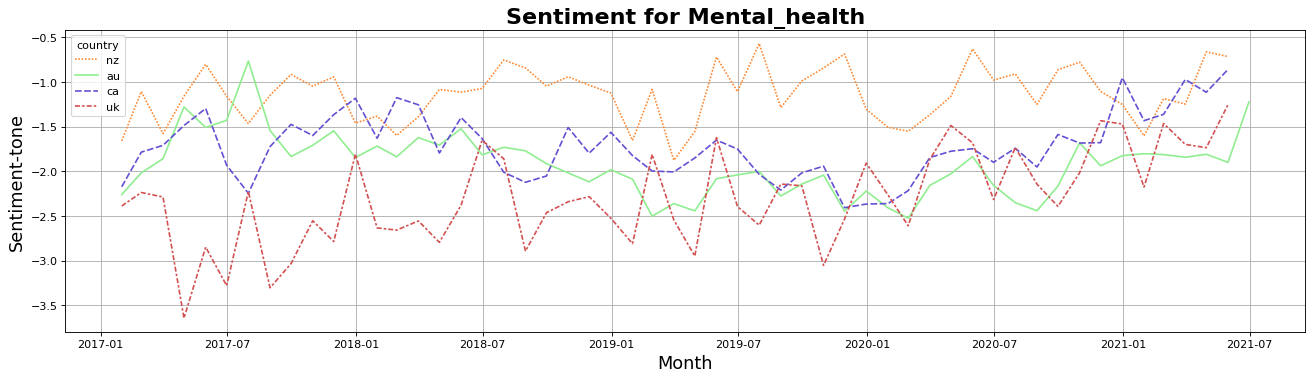

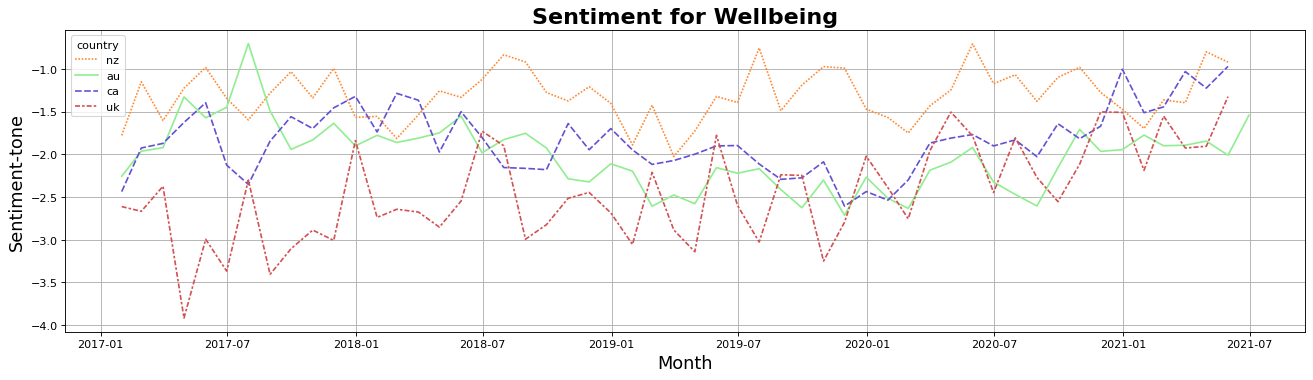

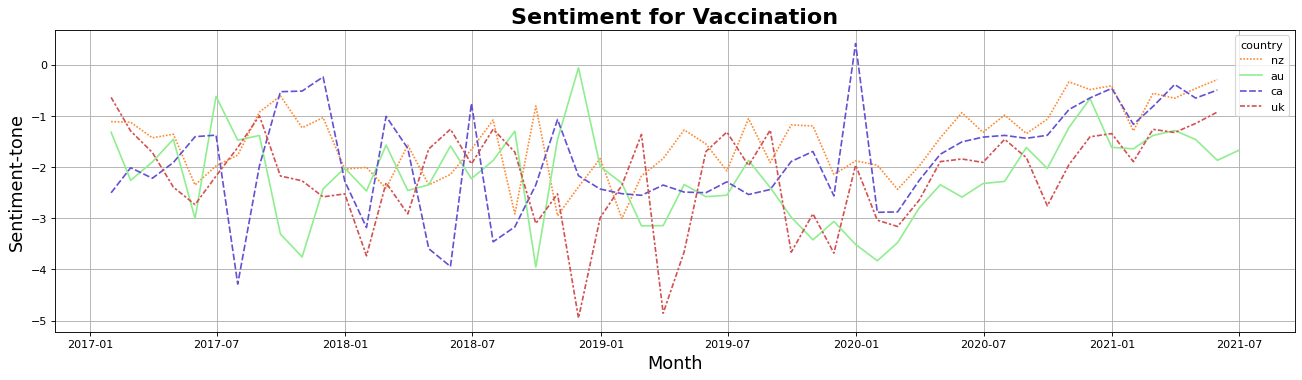

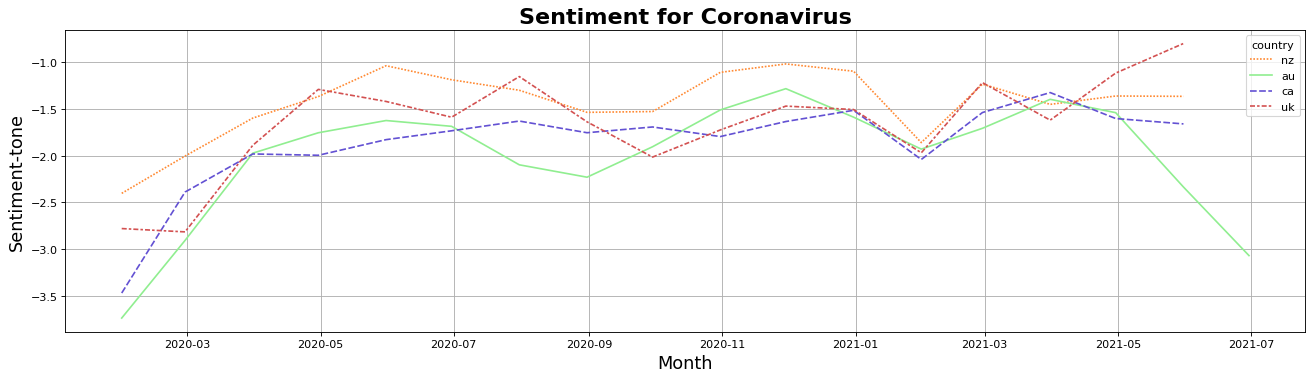

In [136]:
# fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)

def plotting_themes():
    for t in df.columns.tolist()[1::2][:-1]:
        fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
        sns.set_palette(sns.color_palette(colors_div))
        if t == 'Coronavirus':
            sns.lineplot(x='date', y=f'{t}', data=df.loc[(df.year>=2020) & (df.country != 'us')], hue = 'country', style = 'country',hue_order=['nz', 'au','ca','uk'])
        else:    
            sns.lineplot(x='date', y=f'{t}', data=df.loc[(df.year>=2017) & (df.country != 'us')], hue = 'country', style = 'country',hue_order=['nz', 'au','ca','uk'])


        ax.set_title(f'Sentiment for {t.capitalize()}',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
        ax.set_xlabel('Month', fontsize = 16)
        ax.set_ylabel('Sentiment-tone', fontsize = 16)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        # plt.tick_params(axis='y', which='major', labelsize=16)
        # plt.tick_params(axis='x', which='major', labelsize=16)
        plt.legend(title = 'country', loc = 'best',fontsize = 10)
        plt.savefig(f"images/Sentiment for {t.capitalize()}")
        plt.show()

plotting_themes()

In [7]:
# for t in df.columns.tolist()[1::2][:-1]:
#     df[f'avg_{t}']=np.log(df[f'{t}'])

### What themes countries are more concerned towards?

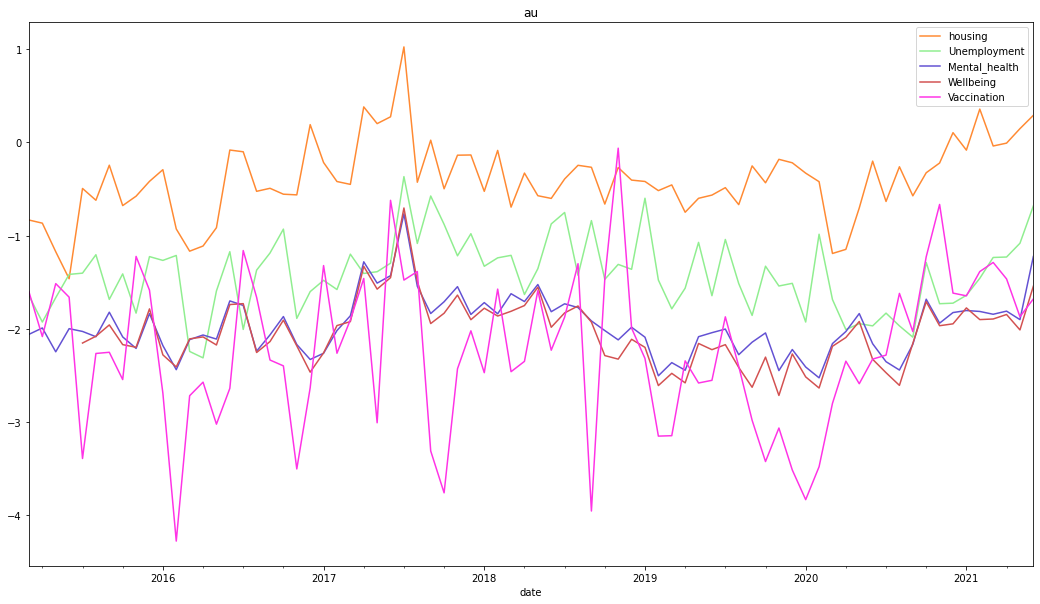

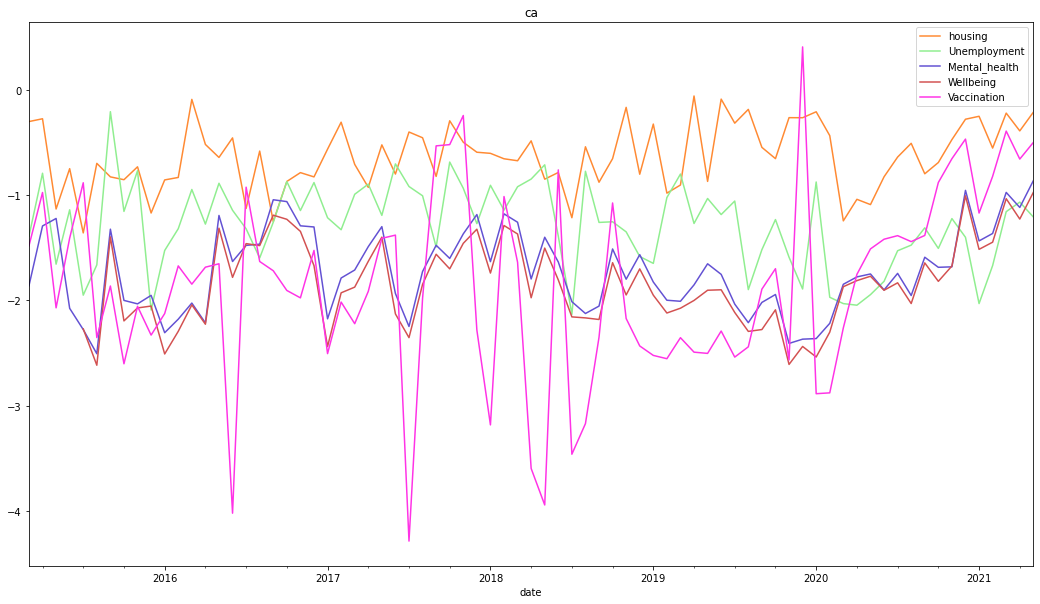

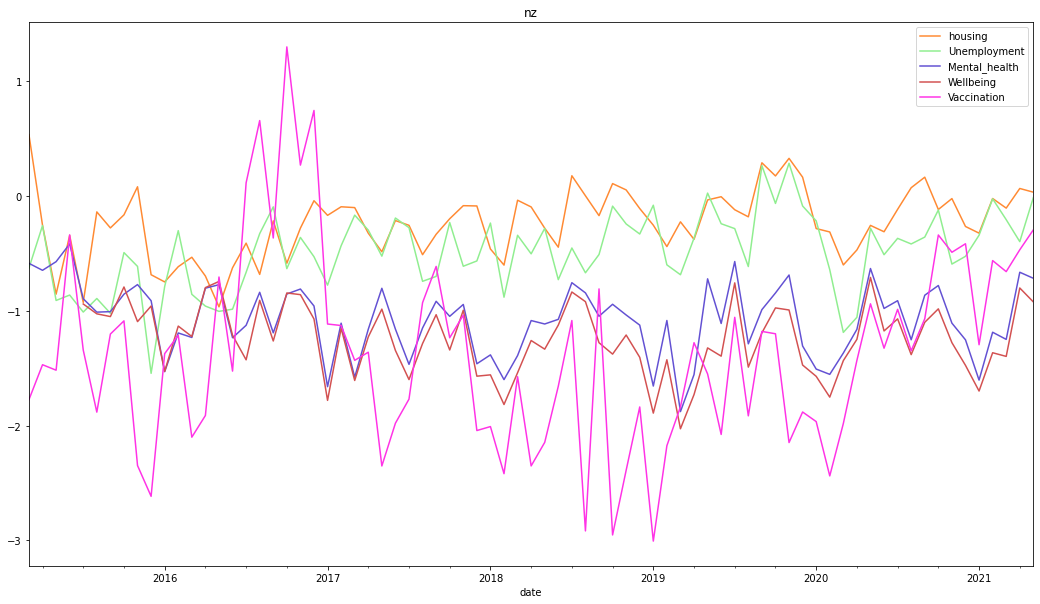

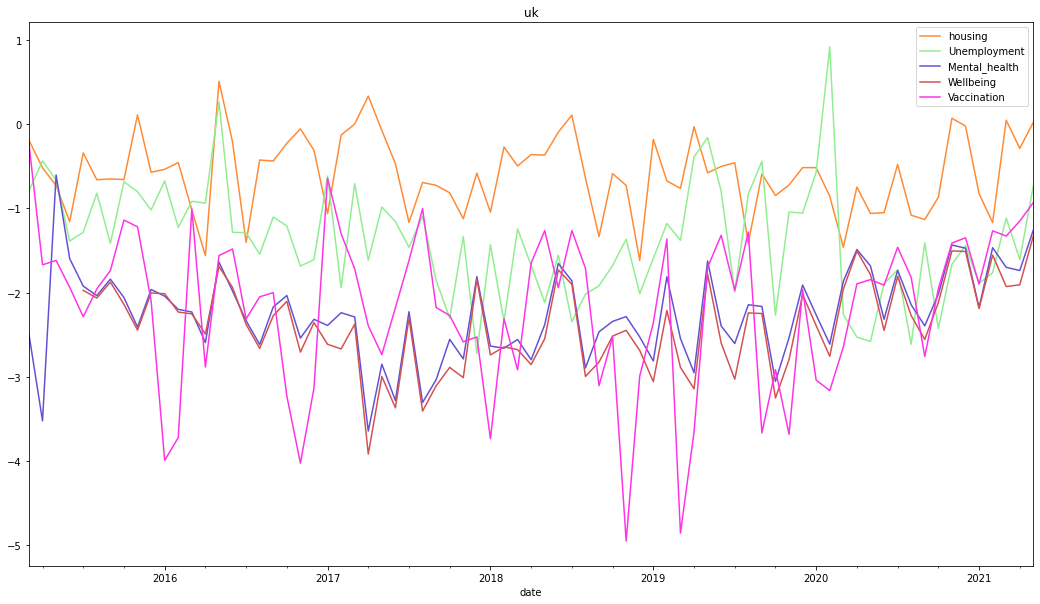

In [12]:
for i in df.country.unique().tolist():
    df.query(f'country == "{i}"').iloc[:,[0,1,3,5,7,9]].set_index('date').plot(figsize=(18, 10), title = f"{i}")
    plt.savefig(f"images/{i}")

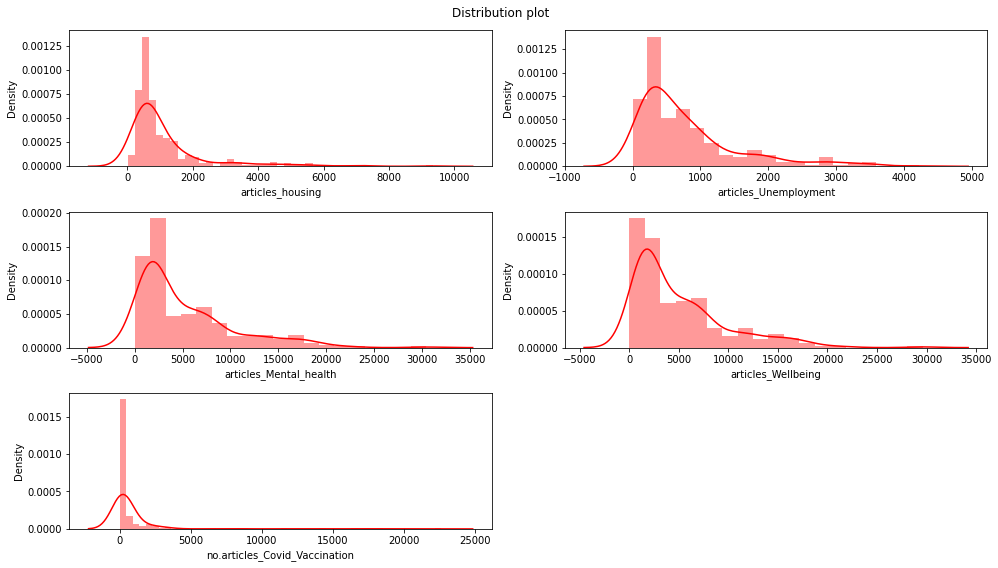

In [13]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(14, 8))
plt.suptitle('Distribution plot')
plt.subplot(3, 2, 1)

sns.distplot(
    df.iloc[:,2],
    color="r",
    axlabel="articles_housing",
)


plt.subplot(3, 2, 2)
sns.distplot(
    df.iloc[:,4],
    color="r",
    axlabel="articles_Unemployment",
)
plt.subplot(3, 2, 3)
sns.distplot(
    df.iloc[:,6],
    color="r",
    axlabel="articles_Mental_health",
)


plt.subplot(3, 2, 4)
sns.distplot(
    df.iloc[:,8],
    color="r",
    axlabel="articles_Wellbeing",
)

plt.subplot(3, 2, 5)
sns.distplot(
    df.iloc[:,10],
    color="r",
    axlabel="no.articles_Covid_Vaccination",
)

plt.tight_layout()
plt.savefig("images/distribution of articles")
plt.show()

In [11]:
d = df.query('country != "us"').groupby(['year','country'])['no.articles_housing'].sum().reset_index()

In [31]:
palette[-2:]

['darkblue', 'black']

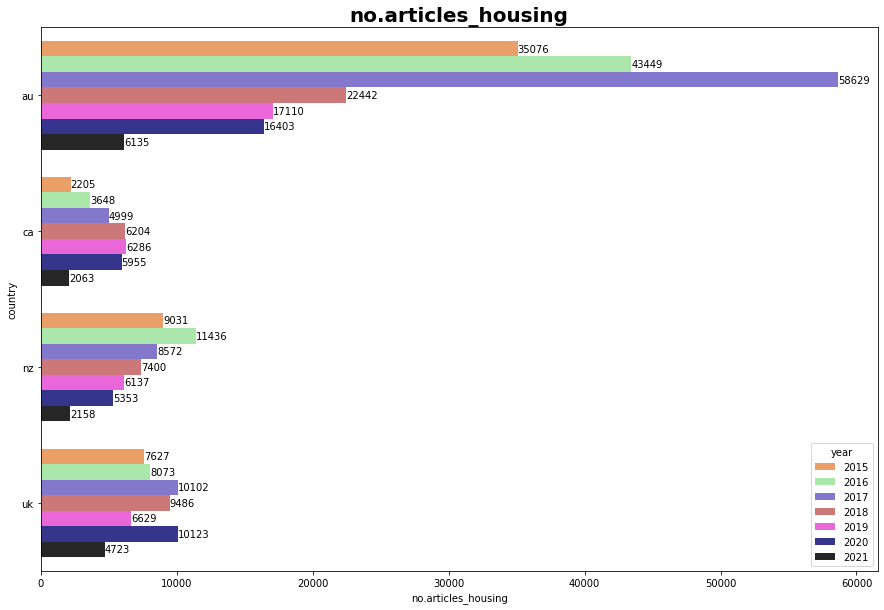

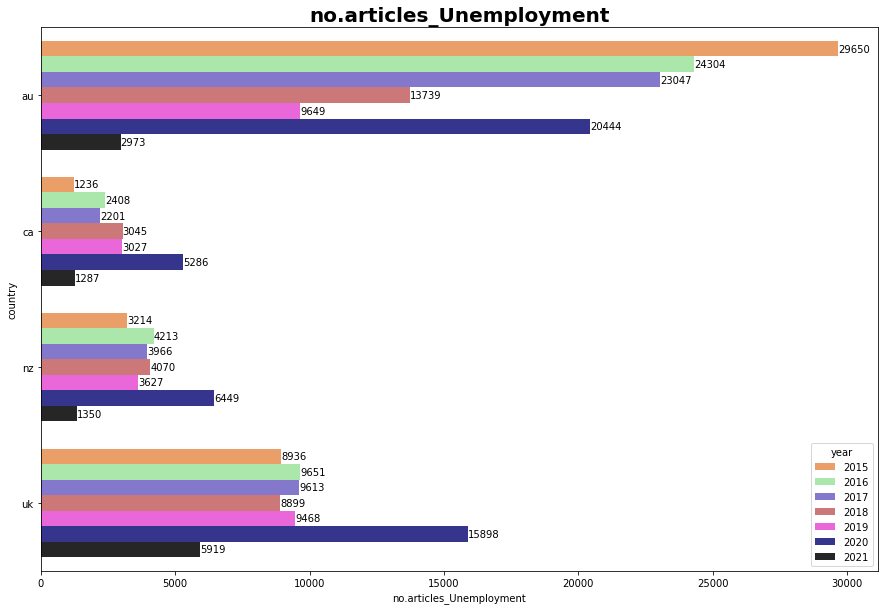

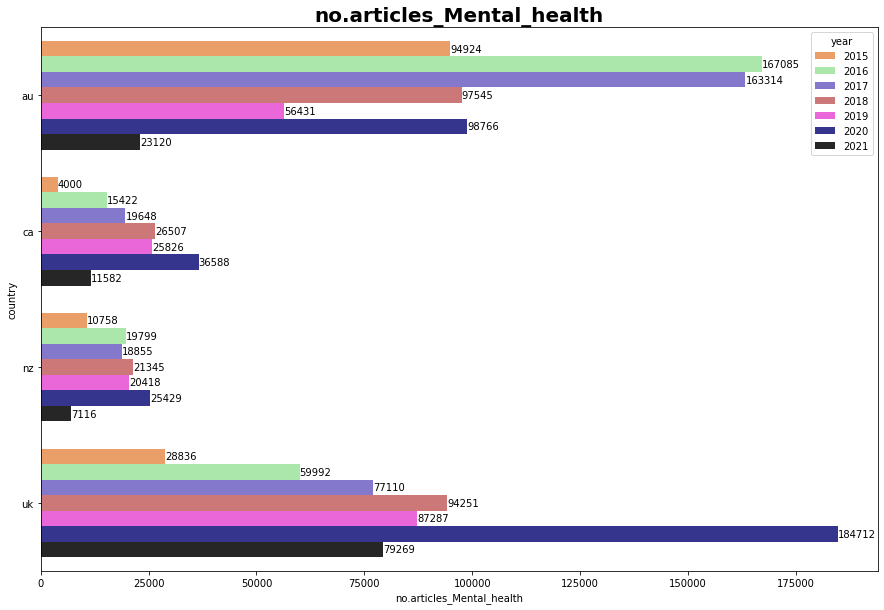

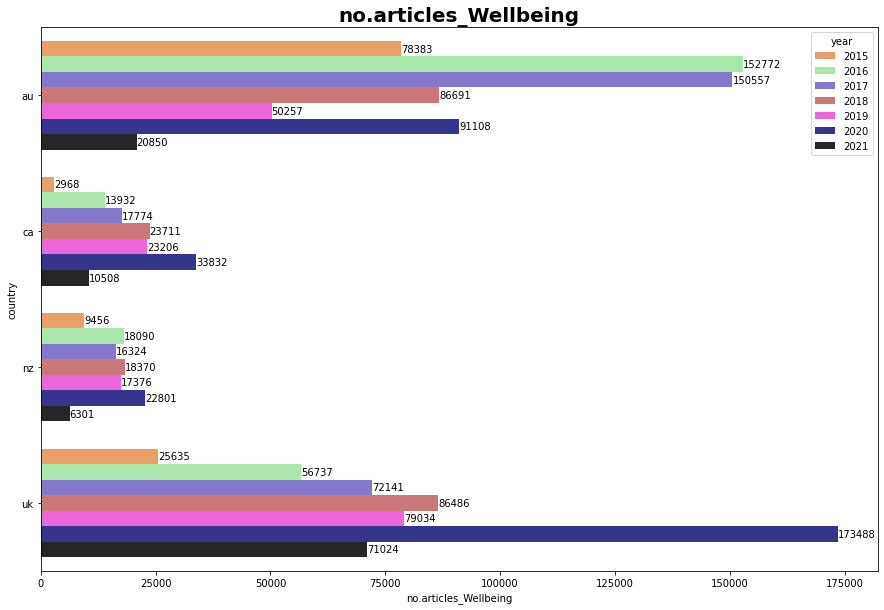

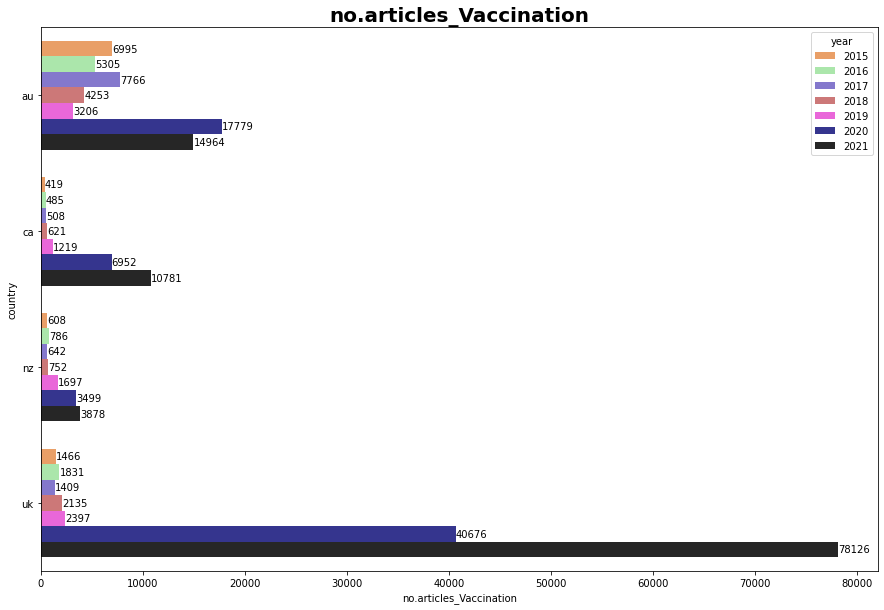

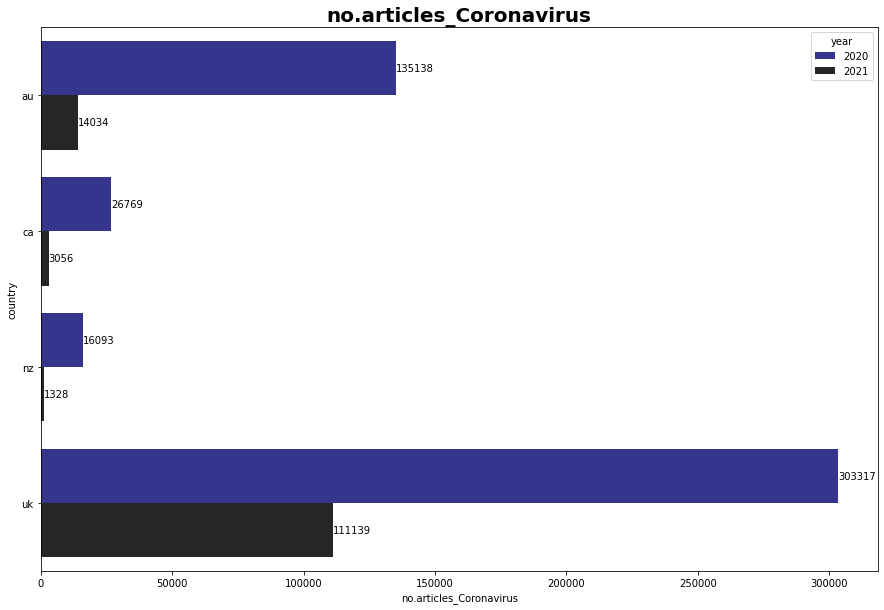

In [32]:
# palette = sns.color_palette("Blues_d")
palette = colors_div + ['darkblue', 'black']
def plot_articles_count():
    
    for t in df.columns.tolist()[2::2][:-1]:
        fig, ax = plt.subplots(figsize=(15, 10))
        if t == 'no.articles_Coronavirus':
            ax = sns.barplot(y='country', x=f'{t}', hue = 'year', data=df.loc[(df.year>=2020) & (df.country != 'us')].groupby(['year','country'])[f'{t}'].sum().reset_index(), ci=None, alpha = 0.85,palette=palette[-2:])#, order=df_nz.explode('themes').themes.value_counts().index[1:10])
        else:
            
            ax = sns.barplot(y='country', x=f'{t}', hue = 'year', data=df.query('country != "us"').groupby(['year','country'])[f'{t}'].sum().reset_index(), ci=None, alpha = 0.85,palette=palette)#, order=df_nz.explode('themes').themes.value_counts().index[1:10])
        ax.set_title(f'{t}',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
        # i=[i for i in range(0,7)]
        for p in ax.patches:
            width = p.get_width()   
            ax.text(width + 1,       
                    p.get_y() + p.get_height() / 2,
                    '{:1.0f}'.format(width), 
                    ha = 'left',  
                    va = 'center') 
        plt.show()
        
plot_articles_count()


In [22]:
# df.set_index('date', inplace=True)
# calplot.calplot(df['housing'], how='sum')

In [62]:
df1 = read_from_s3('swa_insights/merged/','swa_monthly.csv')

Read - swa_monthly.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 1 to 304
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            301 non-null    datetime64[ns]
 1   tone_about_c    301 non-null    float64       
 2   tone_from_c     301 non-null    float64       
 3   source_from_c   301 non-null    int64         
 4   source_about_c  301 non-null    int64         
 5   country         301 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 16.5+ KB
None


In [117]:
df2=df2.iloc[:,[0,3,4,5,6,7]]

In [118]:
df2.to_csv("rolling_average_swa.csv", index = False)

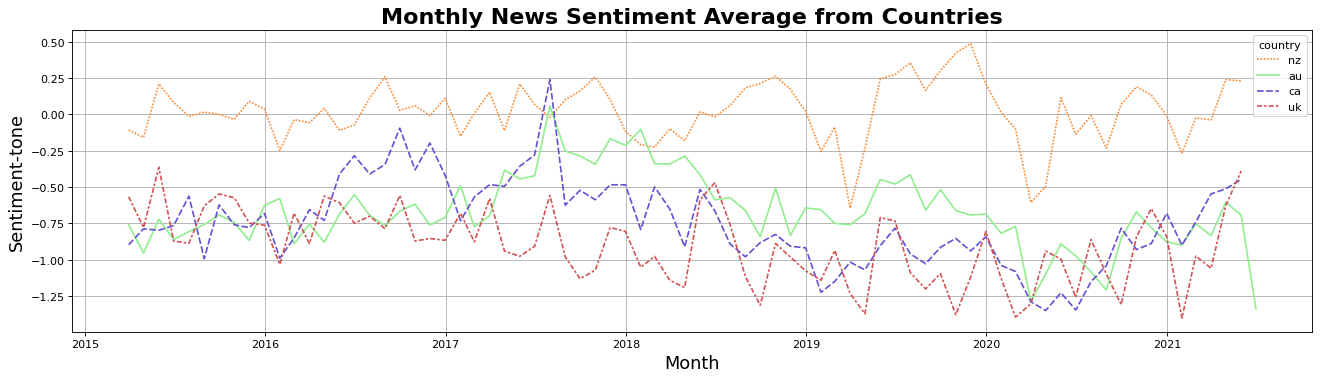

In [122]:

fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
sns.set_palette(sns.color_palette(colors_div))

sns.lineplot(x='date', y='tone_from_c', data=df1, hue = 'country', style = 'country',hue_order=['nz', 'au','ca','uk'])


ax.set_title('Monthly News Sentiment Average from Countries',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16)
ax.set_ylabel('Sentiment-tone', fontsize = 16)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
# plt.tick_params(axis='y', which='major', labelsize=16)
# plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(title = 'country', loc = 'best',fontsize = 10)
plt.savefig("images/Monthly News Sentiment Average from Countries")
plt.show()



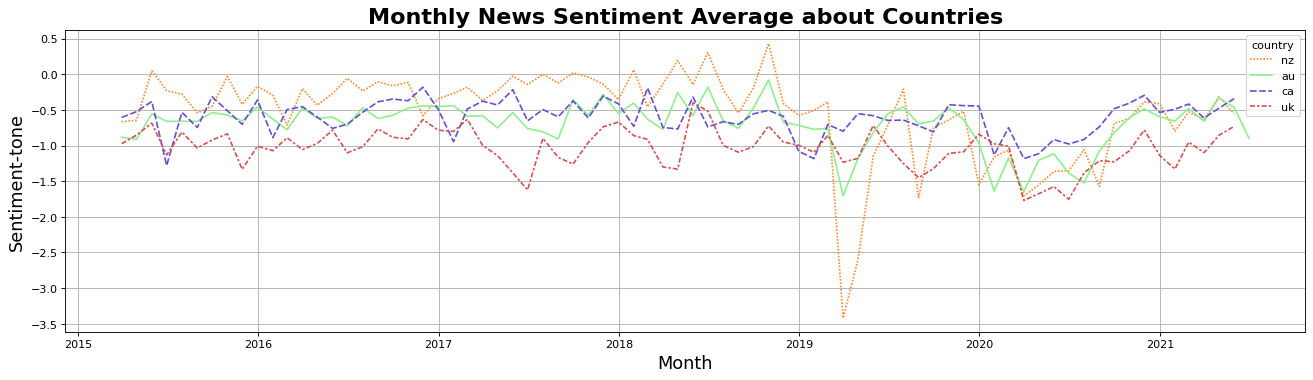

In [123]:
fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
sns.set_palette(sns.color_palette(colors_div))

sns.lineplot(x='date', y='tone_about_c', data=df1, hue = 'country', style = 'country',hue_order=['nz', 'au','ca','uk'])


ax.set_title('Monthly News Sentiment Average about Countries',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16)
ax.set_ylabel('Sentiment-tone', fontsize = 16)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
# plt.tick_params(axis='y', which='major', labelsize=16)
# plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(title = 'country', loc = 'best',fontsize = 10)
plt.savefig("images/Monthly News Sentiment Average about Countries")
plt.show()

In [109]:
df1.iloc[df1.tone_about_c.argmin()]

date              2019-03-31 00:00:00
tone_about_c                -3.419661
tone_from_c                 -0.645342
source_from_c                   13841
source_about_c                 106581
country                            nz
abs_diff                     2.774318
Name: 202, dtype: object

In [64]:
df2 = read_from_s3('swa_insights/merged/','swa_rolling.csv')

Read - swa_rolling.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9028 entries, 11 to 9071
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               9028 non-null   datetime64[ns]
 1   tone_about_c       9028 non-null   float64       
 2   tone_from_c        9025 non-null   float64       
 3   source_from_c      9028 non-null   int64         
 4   source_about_c     9028 non-null   int64         
 5   rolling_7_from_c   8867 non-null   float64       
 6   rolling_7_about_c  8884 non-null   float64       
 7   country            9028 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 634.8+ KB
None


In [66]:
df2 = df2.dropna(subset=['rolling_7_from_c']).reset_index(drop = True)

In [67]:
df2.iloc[:,[0,3,4,5,6,7]]

,date,source_from_c,source_about_c,rolling_7_from_c,rolling_7_about_c,country
0,2015-03-01,4897,3536,-1.020181,-0.627862,au
1,2015-03-02,4911,3560,-0.960810,-0.567775,au
2,2015-03-03,3102,3396,-0.909835,-0.567507,au
3,2015-03-04,3772,3093,-0.977787,-0.686745,au
4,2015-03-05,3525,2780,-0.947967,-0.723769,au
...,...,...,...,...,...,...
8862,2021-05-17,1801,2739,-0.371033,-0.940246,uk
8863,2021-05-18,2171,3303,-0.249727,-0.927568,uk
8864,2021-05-19,1745,2682,-0.275906,-0.937111,uk
8865,2021-05-20,1271,1950,-0.217939,-0.885073,uk


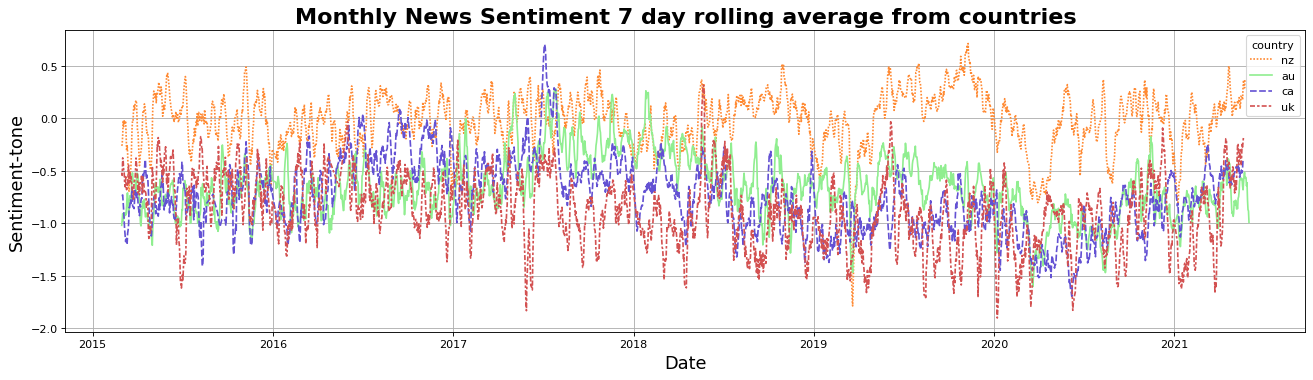

In [124]:
fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
sns.set_palette(sns.color_palette(colors_div))

sns.lineplot(x='date', y='rolling_7_from_c', data=df2, hue = 'country', style = 'country',hue_order=['nz', 'au','ca','uk'])


ax.set_title('Monthly News Sentiment 7 day rolling average from countries',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Sentiment-tone', fontsize = 16)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
# plt.tick_params(axis='y', which='major', labelsize=16)
# plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(title = 'country', loc = 'best',fontsize = 10)
plt.savefig("images/Monthly News Sentiment 7 day rolling average from countries")
plt.show()

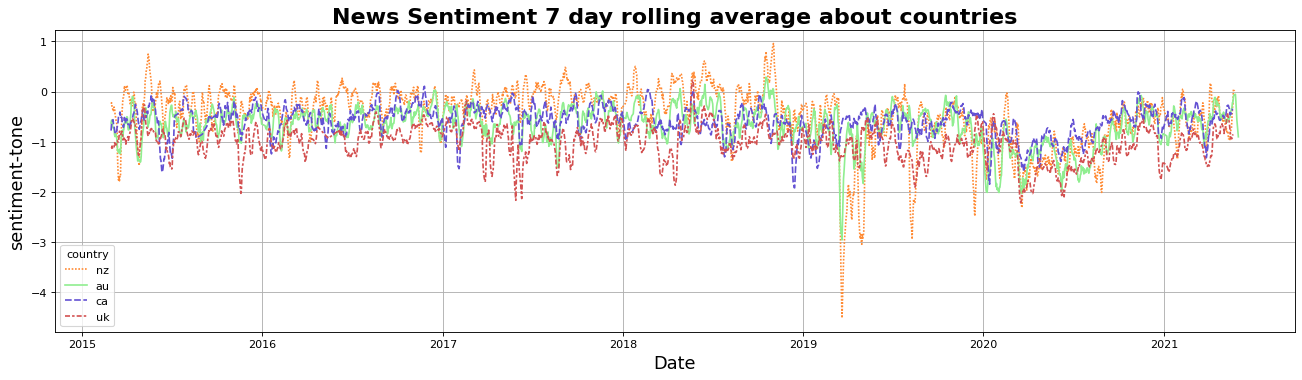

In [141]:
fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
sns.set_palette(sns.color_palette(colors_div))

sns.lineplot(x='date', y='rolling_7_about_c', data=df2, hue = 'country', style = 'country',hue_order=['nz', 'au','ca','uk'])


ax.set_title('Seven News Sentiment 7 day rolling average about countries',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('sentiment-tone', fontsize = 16)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
# plt.tick_params(axis='y', which='major', labelsize=16)
# plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(title = 'country', loc = 'best',fontsize = 10)
plt.savefig("images/Monthly News Sentiment 7 day rolling average about countries")
plt.show()

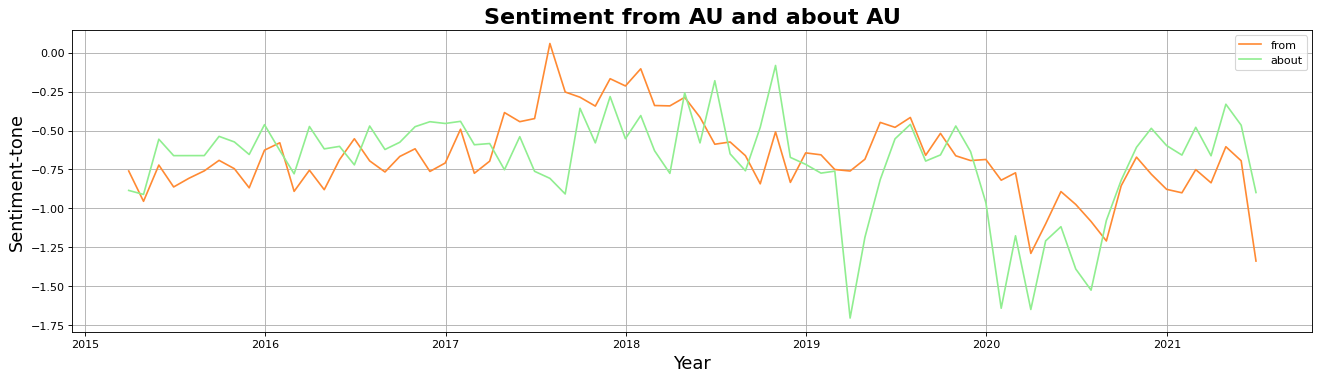

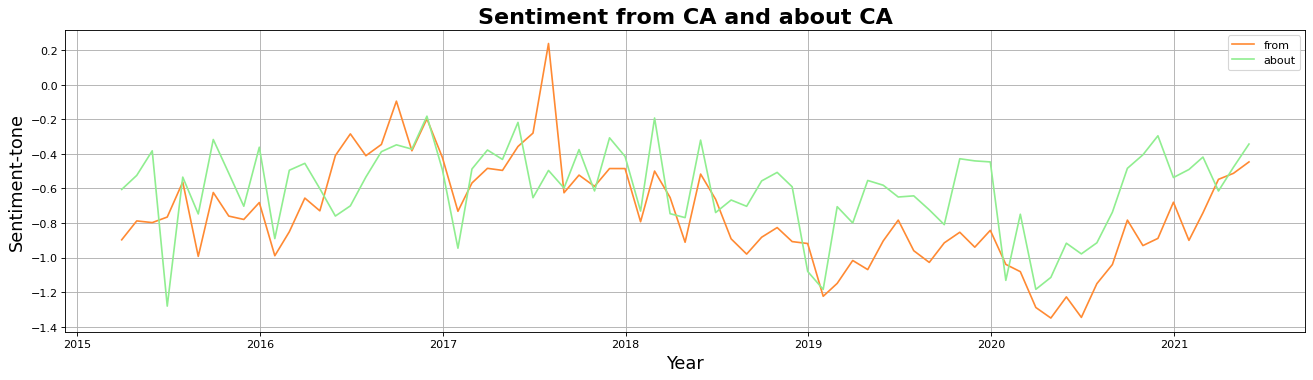

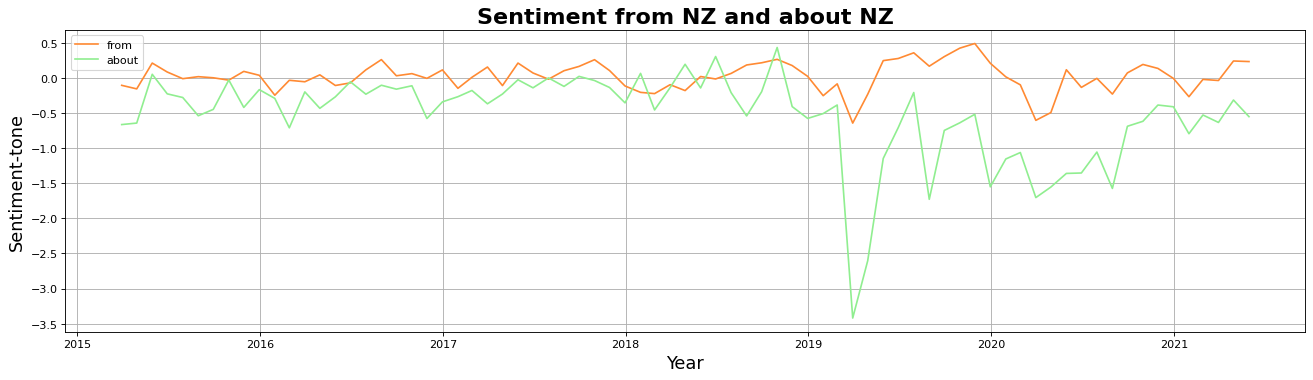

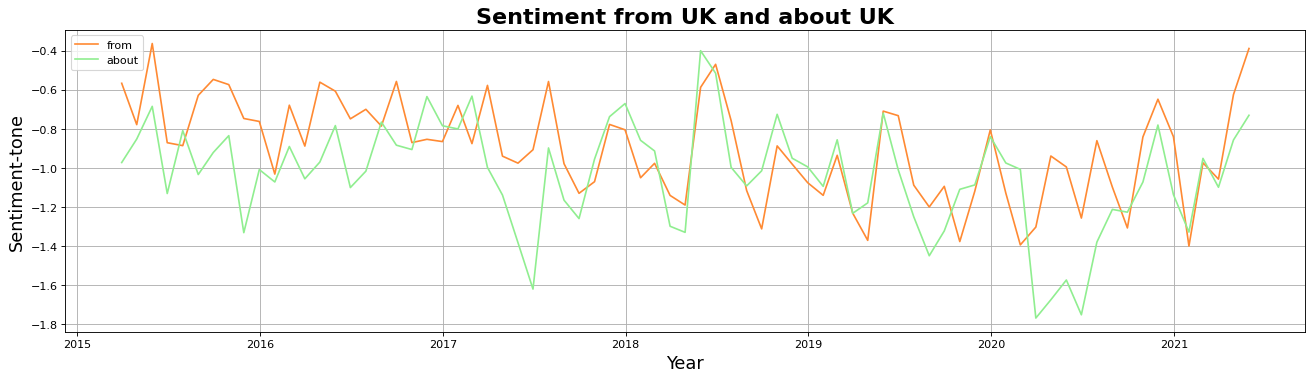

In [131]:


def plot_country():
    for t in df.country.unique().tolist():
        fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
        sns.set_palette(sns.color_palette(colors_div))

        sns.lineplot(x='date', y='tone_from_c', data=df1.query(f'country == "{t}"'))
        sns.lineplot(x='date', y='tone_about_c', data=df1.query(f'country == "{t}"'))


        ax.set_title(f'Sentiment from {t.upper()} and about {t.upper()}',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
        ax.set_xlabel('Year', fontsize = 16)
        ax.set_ylabel('Sentiment-tone', fontsize = 16)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        # plt.tick_params(axis='y', which='major', labelsize=16)
        # plt.tick_params(axis='x', which='major', labelsize=16)
        plt.legend(['from', 'about'], loc = 'best',fontsize = 10)
        plt.savefig(f"images/Sentiment from {t.upper()} and about {t.upper()}")
        plt.show()
        
plot_country()

In [84]:
df1['abs_diff'] = np.abs(df1['tone_from_c'] -df1['tone_about_c']) 

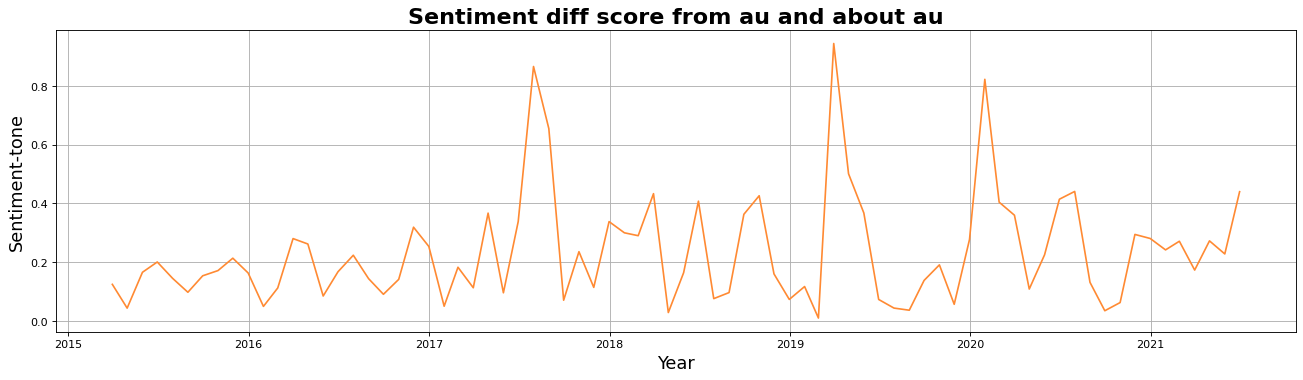

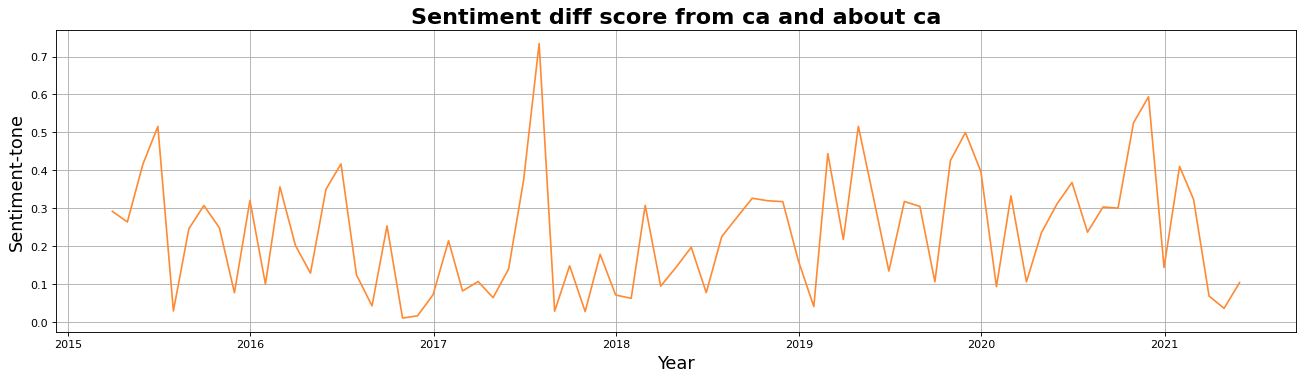

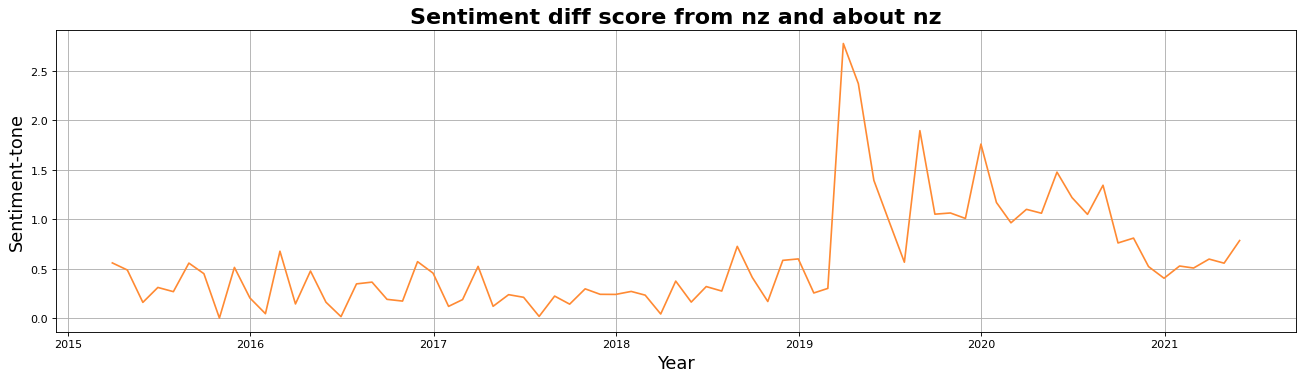

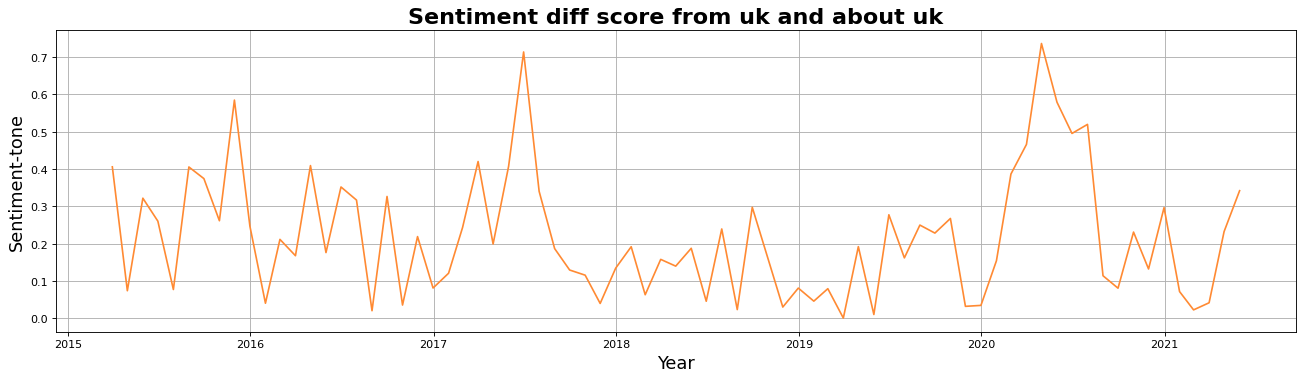

In [85]:
def plot_country_diff():
    for t in df.country.unique().tolist():
        fig, ax = plt.subplots(figsize=(20, 5), dpi = 80)
        sns.set_palette(sns.color_palette(colors_div))

        sns.lineplot(x='date', y='abs_diff', data=df1.query(f'country == "{t}"'))


        ax.set_title(f'Sentiment diff score from {t} and about {t}',  fontsize = 20, loc='center', fontdict=dict(weight='bold'))
        ax.set_xlabel('Year', fontsize = 16)
        ax.set_ylabel('', fontsize = 16)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        # plt.tick_params(axis='y', which='major', labelsize=16)
        # plt.tick_params(axis='x', which='major', labelsize=16)
#         plt.legend(['from', 'about'], loc = 'best',fontsize = 10)
        #         plt.savefig(f"{t}")
        plt.show()
        
plot_country_diff()

### Transparency

In [104]:
df1.groupby('country')['abs_diff','tone_from_c','tone_about_c'].mean().sort_values(by = 'abs_diff')

,abs_diff,tone_from_c,tone_about_c
country,,,
uk,0.220324,-0.901781,-1.034083
au,0.234600,-0.667892,-0.700224
ca,0.235236,-0.745177,-0.606252
nz,0.588024,0.017844,-0.539041


In [89]:
df1.loc[df1.date >=datetime(2019,1,1)].groupby('country')['abs_diff','tone_from_c','tone_about_c'].sum().sort_values(by = 'abs_diff')

,abs_diff,tone_from_c,tone_about_c
country,,,
uk,6.484054,-29.896093,-33.713667
au,7.966155,-23.852080,-26.455855
ca,8.202465,-27.641733,-19.758956
nz,30.252532,0.293309,-29.959224


In [96]:
df1.iloc[df1.tone_from_c.argmax()]

date              2019-11-30 00:00:00
tone_about_c                -0.519975
tone_from_c                  0.487283
source_from_c                   12644
source_about_c                  42751
country                            nz
abs_diff                     1.007258
Name: 210, dtype: object

In [97]:
df1.iloc[df1.tone_about_c.argmax()]

date              2018-10-31 00:00:00
tone_about_c                 0.430528
tone_from_c                  0.261998
source_from_c                   14669
source_about_c                  53052
country                            nz
abs_diff                      0.16853
Name: 197, dtype: object

In [99]:
df1

,date,tone_about_c,tone_from_c,source_from_c,source_about_c,country,abs_diff
1,2015-03-31,-0.884391,-0.759478,116260,97924,au,0.124914
2,2015-04-30,-0.910121,-0.954241,125926,90381,au,0.044120
3,2015-05-31,-0.555741,-0.721650,136138,99942,au,0.165909
4,2015-06-30,-0.661146,-0.862074,119548,85860,au,0.200928
5,2015-07-31,-0.660962,-0.806396,119843,92021,au,0.145434
...,...,...,...,...,...,...,...
300,2021-01-31,-1.329969,-1.401574,71188,135035,uk,0.071606
301,2021-02-28,-0.952311,-0.974906,68520,124405,uk,0.022595
302,2021-03-31,-1.100229,-1.058595,73302,126967,uk,0.041634
303,2021-04-30,-0.858049,-0.625547,60709,114013,uk,0.232502


In [ ]:
ax2 = ax1.twinx()

sns.barplot(data = df, x='x_var', y='y_var_2', alpha=0.5, ax=ax2)